In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import Demand
import Solar
import Price
import Date

In [2]:
## method to run the battery ##

def run_battery(bigdata):
    
    batteryoutput = np.zeros(24)
    soc = np.ones(24)*0
    capacity = 750
    power = 420
    eff = 0.9


    for n in range(0,24):
        if n == 0:
            soc_temp = 0
        else:
            soc_temp = soc[n-1]

        if bigdata['Net Demand'][n] > 0:   #using the battery
            batteryoutput[n] = min(bigdata['Net Demand'][n], soc_temp*eff, power)
            soc[n] = soc_temp - batteryoutput[n]*(1/eff)

        elif bigdata['Net Demand'][n] < 0:     # charge the battery, NOTE NET DEMAND = -VE
            batteryoutput[n] = max(bigdata['Net Demand'][n], -(1/eff)*(capacity - soc_temp), -power)
            soc[n] = soc_temp - batteryoutput[n]*(eff)

        elif bigdata['Net Demand'][n] == 0:      # do nothing
            soc[n] = soc_temp


    ## adds the battery output to total demand and adds to bigdata ##

    bigdata['Net Demand - battery'] = bigdata['Net Demand']-batteryoutput
    bigdata['Running Cost - battery'] = bigdata['Net Demand - battery']*bigdata['Grid Buy Price']
    bigdata['Running Cost - battery'] = bigdata['Running Cost - battery'].clip(lower=0)
    bigdata['Running Profit - battery'] = -bigdata['Net Demand - battery']*bigdata['Grid Sell Price']
    bigdata['Running Profit - battery'] = bigdata['Running Profit - battery'].clip(lower=0)
    bigdata['soc - battery'] = soc
    bigdata['battery output - battery'] = batteryoutput
    
    #bigdata = bigdata.round(3)
    ## returns the new bigdata ##
    
    return bigdata

In [13]:
## initialises the daily cost vectors ##
yes_battery_cost = np.zeros(365)
yes_battery_profit = np.zeros(365)
_import_ = np.zeros(24*365)
_export_ = np.zeros(365)
_excess_ = np.zeros(24*365)

for n in range(0, 365):

    ## loads in the data ##

    daywanted = n+1
    datewanted = Date.getdatewanted(daywanted, 2014)
    totaldemand = Demand.gettotaldemand(daywanted)
    solarsupply = Solar.getsolarsupply(daywanted)
    buyprice = Price.getconstantbuyprice(daywanted)
    sellprice = Price.getconstantsellprice(daywanted)
    bigdata = pd.concat([totaldemand, solarsupply, buyprice, sellprice], axis=1)
    bigdata['Net Demand'] = bigdata['Total Demand (kWh)']-bigdata['Total Supply (kWh)']
    bigdata['Running Cost'] = bigdata['Grid Buy Price']*bigdata['Net Demand']
    bigdata['Running Cost'] = bigdata['Running Cost'].clip(lower=0)
    bigdata['Running Profit'] = -bigdata['Grid Sell Price']*bigdata['Net Demand']
    bigdata['Running Profit'] = bigdata['Running Profit'].clip(lower=0)

    ## runs the battery for that day ##

    bigdata = run_battery(bigdata)

    ## adds the day into the year vector ##

    for q in range(24):
    
        if bigdata['Net Demand - battery'][q] < 0:
            _excess_[n*24+q] = bigdata['Net Demand - battery'][q]*-1
            
        if bigdata['Net Demand - battery'][q] > 0:
            _import_[n*24+q] = bigdata['Net Demand - battery'][q]



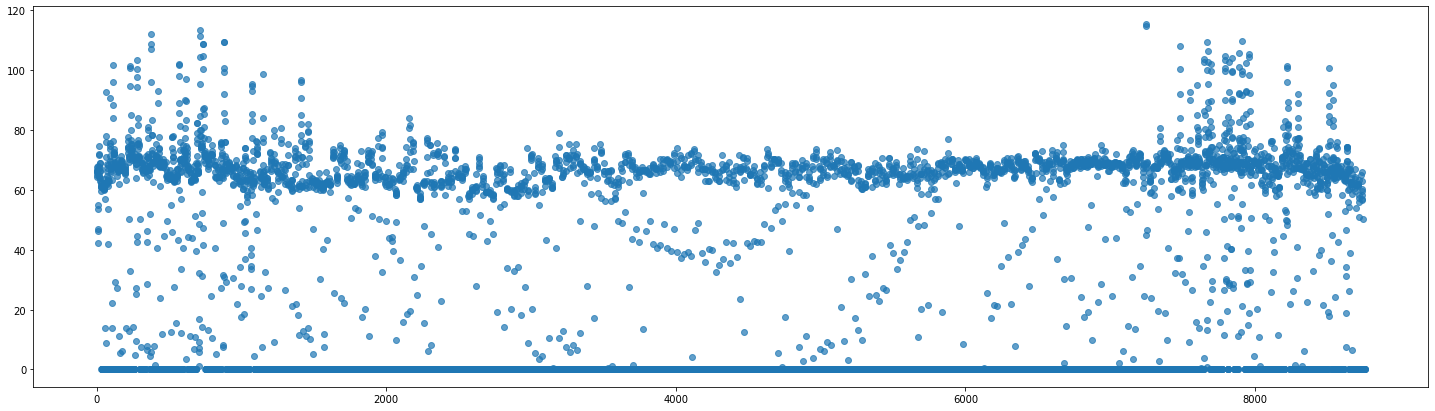

In [15]:
d = np.array([d for d in range(24*365)])

fig, ax = plt.subplots(figsize=[25,7])

# ax.plot(_excess_)
ax.scatter(d, _import_, alpha = 0.7)

In [14]:
_import_

array([66.64 , 64.335, 65.835, ...,  0.   ,  0.   ,  0.   ])

In [16]:
importing = pd.DataFrame(_import_)

In [18]:
importing.to_csv('Import_vector.csv')